**This section is for preparing the requirements for fine-tuning a pre-trained BERT model, specifically a ROBERTa variant**

In [1]:
# Install the following libraries using pip
%pip install evaluate
%pip install transformers
%pip install --upgrade accelerate
%pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.17.3
    Uninstalling huggingface-hub-0.17.3:
      Successfully uninstalled huggingface-hub-0.17.3
     ━

In [2]:
# Import necessary libraries to be used for the entire notebook
import evaluate as ev
import numpy as np
from datasets import load_dataset
from transformers import RobertaTokenizer, DataCollatorWithPadding, RobertaForSequenceClassification, TrainingArguments, Trainer, pipeline

**This section is for loading and preprocessing the dataset**

In [3]:
# Load the dataset as a Dataset Dictionary containing "train", "validation", and "test"
# hsf stands for Hate Speech Filipino
hsf = load_dataset("csv", data_files={"train": "./unique_train_dataset.csv", "validation": "./unique_validation_dataset.csv", "test": "./unique_test_dataset.csv"})

# Test if the dataset was loded correctly
print(hsf["train"][5])
print(hsf["validation"][2])
print(hsf["test"][3])

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

{'text': 'Ang sinungaling sa umpisa ay sinungaling hanggang dulo VP Leni Marcos Sinungaling panalo Natin Para Sa Lahat Leni Kiko', 'label': 1}
{'text': ' This is expected as we use different methodologies and Pulse Asia surveyed not the entire PH population but only the C D and E PH Vote', 'label': 0}
{'text': ' [USERNAME]wish this is just a nightmare that could end Ma Pa we failed again let leni lead never again kakampink Sa Gobyernong Tapat Angat Buhay Lahat', 'label': 0}


In [ ]:
# # Uncomment to check dataset distribution
# import pandas as pd

# # Load train, validation, and test datasets
# train_df = pd.read_csv("./unique_train_dataset.csv")
# val_df = pd.read_csv("./unique_validation_dataset.csv")
# test_df = pd.read_csv("./unique_test_dataset.csv")

# # Printing the num of hate and non-hate speech
# print(f"Training Dataset:\n{train_df['label'].value_counts()}")
# print(f"\nValidation Dataset:\n{val_df['label'].value_counts()}")
# print(f"\nTesting Dataset:\n{test_df['label'].value_counts()}")

# # Print total
# print(f"Total: {len(train_df.index) + len(val_df.index) + len(test_df.index)}")

Training Dataset:
1    10994
0    10780
Name: label, dtype: int64

Validation Dataset:
1    1415
0    1385
Name: label, dtype: int64

Testing Dataset:
0    1412
1    1398
Name: label, dtype: int64
Total: 27383


In [4]:
# Create a list of stopwords from English and Filipino to remove from the wordcloud
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

# Get the list of English stopwords
english_stopwords = set(stopwords.words('english'))

print(english_stopwords)

{'me', "doesn't", 've', "you'll", 'the', 'only', 'yourselves', 'into', 'same', 'after', 'ours', 'nor', 'and', 'hasn', 'isn', 'mustn', 'but', 'there', 'she', "she's", 'all', 'wasn', 'other', "you've", 'through', 'then', 'those', 'be', 'does', 'against', 'i', 'what', 'myself', "shan't", 'some', 'has', 'before', 'not', 'below', 'when', 'too', 'that', 'haven', 'these', 'hadn', 'while', 'as', 'down', 'both', "mustn't", 'how', 'under', "wouldn't", 'ma', 'because', "couldn't", 'our', "aren't", "needn't", 'ourselves', 'with', 'above', 't', 'any', "haven't", 'his', "that'll", 'most', "hadn't", "mightn't", "hasn't", 'during', 'can', "weren't", 'on', 'such', 'y', 'ain', "shouldn't", 'again', 'have', 'an', 'why', 'it', 'for', 'won', 'hers', "didn't", 'itself', 'of', "wasn't", "it's", 're', 'was', 'herself', 'weren', 'himself', 'here', 'don', 'your', 'once', 'do', 'couldn', 'between', 'in', "won't", 'll', 'no', 'few', 'very', 'to', 'o', 'they', 'he', 'did', 'doing', 'each', 'their', 'themselves', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
# Load Filipino stopwords from a .txt file taken from
# https://github.com/explosion/spaCy/blob/master/spacy/lang/tl/stop_words.py and
# https://github.com/stopwords-iso/stopwords-tl

# Initialize an empty list for Filipino stopwords
filipino_stopwords = []

# Load Filipino stopwords from the first .txt file
with open('genediazjr-tagalog.txt', 'r', encoding='utf-8') as file1:
    filipino_stopwords.extend([line.strip() for line in file1])

# Load Filipino stopwords from the second .txt file
with open('stop_words_fil.txt', 'r', encoding='utf-8') as file2:
    filipino_stopwords.extend([line.strip() for line in file2])

print(filipino_stopwords)

['ako', 'sa', 'akin', 'ko', 'aking', 'sarili', 'kami', 'atin', 'ang', 'aming', 'amin', 'ating', 'ka', 'iyong', 'iyo', 'inyong', 'siya', 'kanya', 'mismo', 'ito', 'nito', 'kanyang', 'sila', 'nila', 'kanila', 'kanilang', 'kung', 'ano', 'alin', 'sino', 'kanino', 'na', 'mga', 'iyon', 'am', 'ay', 'maging', 'naging', 'mayroon', 'may', 'nagkaroon', 'pagkakaroon', 'gumawa', 'ginagawa', 'ginawa', 'paggawa', 'ibig', 'dapat', 'maaari', 'marapat', 'kong', 'ikaw', 'tayo', 'hindi', 'namin', 'gusto', 'nais', 'niyang', 'nilang', 'niya', 'huwag', 'ginawang', 'gagawin', 'maaaring', 'sabihin', 'narito', 'kapag', 'ni', 'nasaan', 'bakit', 'paano', 'kailangan', 'walang', 'katiyakan', 'isang', 'at', 'pero', 'o', 'dahil', 'bilang', 'hanggang', 'habang', 'ng', 'pamamagitan', 'para', 'tungkol', 'laban', 'pagitan', 'panahon', 'bago', 'pagkatapos', 'itaas', 'ibaba', 'mula', 'pataas', 'pababa', 'palabas', 'ibabaw', 'ilalim', 'muli', 'pa', 'minsan', 'dito', 'doon', 'saan', 'lahat', 'anumang', 'kapwa', 'bawat', 'ilan

In [8]:
# Merge English and Filipino stopwords into one list
combined_stopwords = english_stopwords.union(filipino_stopwords)

# This is to remove USERNAME from the wordcloud since it was used to mask
# any and all Twitter @usernames
combined_stopwords.add("USERNAME")

print(combined_stopwords)

{'ve', 'the', 'kanya', 'pagkakaroon', 'muli', 'same', 'USERNAME', 'ang', 'doon', 'ito', 'mismo', 'all', 'wasn', 'kanilang', "you've", 'those', 'has', 'nasaan', 'kaya', 'kulang', 'too', 'that', 'pa', 'apat', 'both', "mustn't", 'how', 'because', 'our', "aren't", 'any', 'most', "mightn't", "hasn't", 'during', 'y', 'have', 'why', 'lahat', 'huwag', 'it', 'ating', 'kanila', 'naging', 'nabanggit', 'for', 're', 'dalawa', 'himself', "won't", 'll', 'no', 'iyong', 'noon', 'very', 'o', 'ikaw', 'did', 'lamang', 'their', 'is', 'been', 'bakit', 'lima', 'at', 'shan', 'pataas', 'iyon', 'ginagawa', 'siya', 'narito', 'being', 'tulad', 'who', 'whom', 'them', 'bilang', 'mayroon', 'gusto', 'kung', 'laban', 'masyado', 'but', 'then', 'through', 'i', 'anumang', 'before', 'namin', 'karamihan', 'down', 'sabihin', 'under', 'ma', "needn't", 'mula', 'his', "weren't", 'ay', 'on', 'paano', 'ain', 'pagkatapos', 'walang', 'ilan', 'pababa', 'itself', "it's", 'alin', 'was', 'here', 'don', 'your', 'between', 'pumunta', 'f

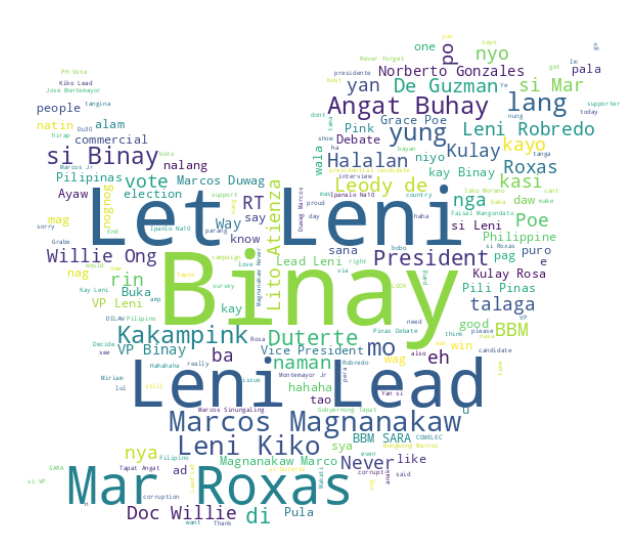

In [12]:
# This cell is for creating a word cloud from all three sets of data
from wordcloud import WordCloud
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Concatenate the text data from train, validation, and test datasets
combined_text = ' '.join(hsf['train']['text'] + hsf['validation']['text'] + hsf['test']['text'])

# We used the Philippines as mask
twitter_mask = np.array(Image.open("Twitter.jpg"))

# Generate the word cloud from the combined text
wordcloud = WordCloud(
    scale=1,
    background_color="white",
    mask=twitter_mask,
    stopwords=combined_stopwords,
).generate(combined_text)

# Create a figure and axis with custom background color
fig, ax = plt.subplots(figsize=(8, 8), facecolor="white")

# Display the word cloud on the custom background
ax.imshow(wordcloud, interpolation="bilinear")
ax.axis("off")

# Set the title
ax.set_title("Combined Word Cloud for Train, Validation, and Test Data", color="white")

# Show the word cloud
plt.show()

In [13]:
# Laod the tokenizer that comes with jcblaise/roberta-tagalog-base for preprocessing
tokenizer = RobertaTokenizer.from_pretrained('jcblaise/roberta-tagalog-base')

In [14]:
# Create preprocess function for preprocessing, tokenization, and truncation
def preprocess_function(tweets):
    return tokenizer(tweets["text"], truncation=True, max_length=512)

In [15]:
# Map the function to preprocess all the texts in the datasets
tokenized_hsf = hsf.map(preprocess_function, batched=True)

Map:   0%|          | 0/21772 [00:00<?, ? examples/s]

Map:   0%|          | 0/2800 [00:00<?, ? examples/s]

Map:   0%|          | 0/2810 [00:00<?, ? examples/s]

In [32]:
# Show samples of the tokenized datasets
print("Training: ")
for x in range(4):
  print("text: ", tokenized_hsf["train"][x]["text"])
  print("label: ", tokenized_hsf["train"][x]["label"])
  print("input_ids: ", tokenized_hsf["train"][x]["input_ids"])
  print("attention_mask", tokenized_hsf["train"][x]["attention_mask"])
  print("=" * 29)

Training: 
text:  Presidential candidate Mar Roxas implies that the govt should not be liable re Laglag Bala Laglag Bayag na ata ito
label:  1
input_ids:  [0, 12076, 12754, 10183, 845, 4647, 2856, 911, 1302, 479, 18218, 88, 5099, 1650, 1111, 8375, 1489, 419, 3618, 4764, 17247, 3618, 4764, 354, 1230, 269, 9785, 365, 2]
attention_mask [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
text:  Parang may mali na sumunod ang patalastas ng Nescaf Coffee Black sa commercial ni Binay Parang lang naman
label:  1
input_ids:  [0, 12316, 379, 3784, 269, 3870, 277, 26104, 271, 366, 307, 4248, 74, 18136, 7262, 268, 10985, 355, 4314, 5576, 443, 472, 2]
attention_mask [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
text:  Bet ko Pula Ang Kulay Ng Posas
label:  1
input_ids:  [0, 20853, 380, 311, 404, 438, 19120, 1075, 311, 26394, 2]
attention_mask [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
text:  [USERNAME] kakampink
label:  0
input_ids:  [0, 63, 4826, 

In [31]:
print("Validation: ")
for x in range(4):
  print("text: ", tokenized_hsf["validation"][x]["text"])
  print("label: ", tokenized_hsf["validation"][x]["label"])
  print("input_ids: ", tokenized_hsf["validation"][x]["input_ids"])
  print("attention_mask", tokenized_hsf["validation"][x]["attention_mask"])
  print("=" * 29)

Validation: 
text:  VinTee [USERNAME] [USERNAME] and [USERNAME] Kaya Di aasenso ang pinas pag marami ang ganitong mentalidad daming martyr daw ninakawan na pinagsinungalingan pa niyurak yurak na e patuloy pa ring minamahal kc nga martyr daw in short sobrang tanga Let Leni Lead
label:  1
input_ids:  [0, 58, 276, 56, 1473, 1546, 4826, 2679, 2382, 10522, 65, 1546, 4826, 2679, 2382, 10522, 65, 596, 1546, 4826, 2679, 2382, 10522, 65, 1497, 993, 576, 22926, 277, 3693, 304, 1538, 277, 2106, 13071, 692, 10058, 6720, 4455, 1105, 13778, 588, 269, 3906, 9015, 358, 4613, 359, 287, 605, 359, 287, 269, 470, 1585, 358, 1485, 8979, 12258, 616, 6720, 4455, 1105, 382, 5537, 2949, 14554, 9630, 7775, 7557, 2]
attention_mask [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
text:  binays sidekicks were employees of makati city hall  how were the

In [33]:
print("Testing: ")
for x in range(4):
  print("text: ", tokenized_hsf["test"][x]["text"])
  print("label: ", tokenized_hsf["test"][x]["label"])
  print("input_ids: ", tokenized_hsf["test"][x]["input_ids"])
  print("attention_mask", tokenized_hsf["test"][x]["attention_mask"])
  print("=" * 29)

Testing: 
text:  Binay Patuloy ang kahirapan dahil sa maling pamamahala [USERNAME]
label:  0
input_ids:  [0, 38, 2562, 9225, 277, 5367, 453, 268, 5324, 4423, 1546, 4826, 2679, 2382, 10522, 65, 2]
attention_mask [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
text:  SA GOBYERNONG TAPAT WELCOME SA BAGUO ANG LAHAT! Kulay Rosas Ang Bukas Let Leni Kiko Lead Let Leni Lead panalo Natin Para Sa Lahat  [USERNAME]
label:  0
input_ids:  [0, 1674, 15825, 38, 61, 2679, 50, 6447, 22493, 10684, 554, 5331, 3003, 10522, 3952, 354, 2147, 57, 51, 8090, 25140, 5, 19120, 2583, 282, 438, 19041, 9630, 7775, 18474, 7557, 9630, 7775, 7557, 3889, 1236, 276, 2069, 627, 2851, 225, 1546, 4826, 2679, 2382, 10522, 65, 2]
attention_mask [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
text:  wait so ur telling me Let Leni Lead mo pero NYONG UYAB BBM SUPPORTER?!??!!!????? to me thats like dating a trump supporter fuck n

**This section is for preparation of hyperparameters to be used as arguments to train the model**

In [ ]:
# Dynamically pad the texts to the longest length instead of max length
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# Compute for accuracy during training
accuracy = ev.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
# Create mappings of label to their corresponding textual values and vice versa
id2label = {0: "NOT HATE", 1: "HATE"}
label2id = {"NOT HATE": 0, "HATE": 1}

In [ ]:
# Load the model using jcblaise/roberta-tagalog-base for training
model = RobertaForSequenceClassification.from_pretrained(
    "jcblaise/roberta-tagalog-base", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at jcblaise/roberta-tagalog-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# View the model architecture by simply calling model
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
# Freeze BERT model layers
for param in model.base_model.parameters():
    param.requires_grad = False

#  # Unfreeze BERT model layers
# for param in model.base_model.parameters():
#     param.requires_grad = True

In [ ]:
# Set up the hyperparameters to be used for fine-tuning using TrainingArguments
training_args = TrainingArguments(
    output_dir="roberta-tagalog-base-philippine-elections-2016-2022-hate-speech",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=False,
    push_to_hub=False,
    optim="adamw_torch" # To avoid using deprecated AdamW Optimizer
)

In [ ]:
# Set up the trainer to handle the training loop with the previously set up model,
# training_args, datasets, tokenizer, data_collator, and compute_metrics
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_hsf["train"],
    eval_dataset=tokenized_hsf["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [ ]:
# Start the training loop
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.352500,0.336572,0.861786
2,0.234500,0.344848,0.870714
3,0.154400,0.562607,0.863214
4,0.079700,0.620562,0.868214
5,0.045500,0.885404,0.867143
6,0.030200,1.010216,0.855714
7,0.016900,0.986193,0.862500
8,0.009800,1.112649,0.864643
9,0.006000,1.154201,0.866429
10,0.003600,1.177272,0.864286


TrainOutput(global_step=13610, training_loss=0.09241668516708419, metrics={'train_runtime': 3276.2838, 'train_samples_per_second': 66.453, 'train_steps_per_second': 4.154, 'total_flos': 8187979042811040.0, 'train_loss': 0.09241668516708419, 'epoch': 10.0})

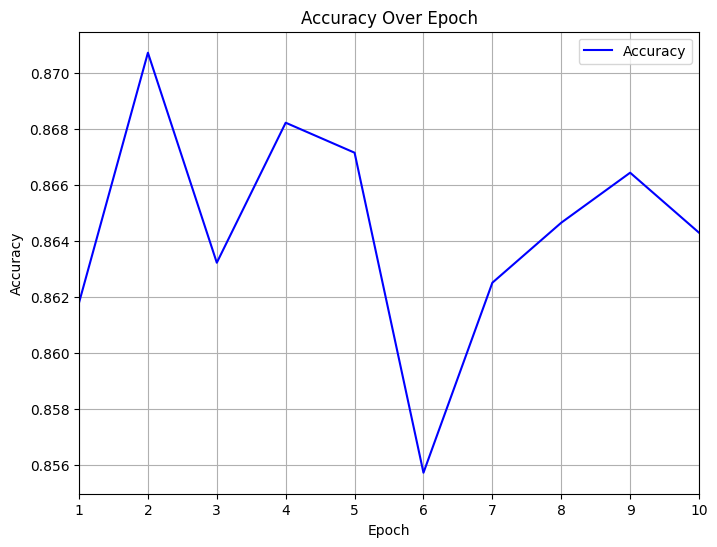

In [1]:
# After training over 10 epochs (solely for the purpsoe of seeing how overfitting happens),
# We can create a plot with the training logs given above as lists
# This code cell is for displaying the accuracy over epoch graph

epoch_numbers = [x for x in range(1, 11)]
accuracy_values = [0.861786,
                   0.870714,
                   0.863214,
                   0.868214,
                   0.867143,
                   0.855714,
                   0.862500,
                   0.864643,
                   0.866429,
                   0.864286]

# Create a line graph
plt.figure(figsize=(8, 6))
plt.plot(epoch_numbers, accuracy_values, linestyle='-', color='b', label='Accuracy')

# Customize the graph
plt.title('Accuracy Over Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.xticks(epoch_numbers)
plt.xlim(epoch_numbers[0], epoch_numbers[-1])

# Show the graph
plt.show()

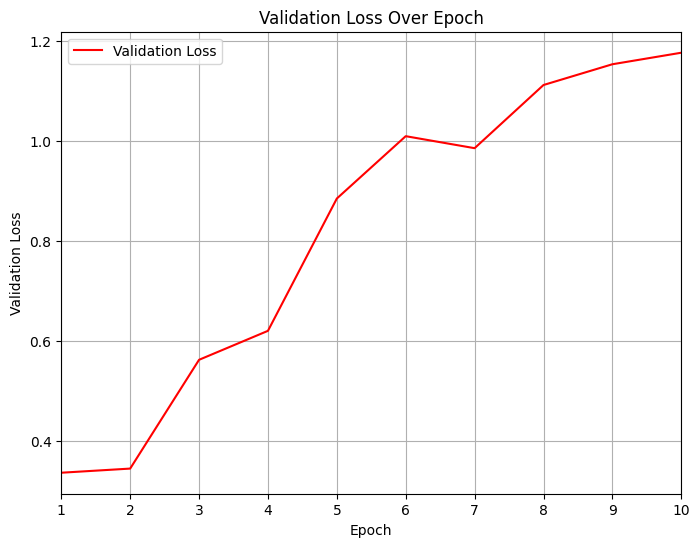

In [2]:
# This code cell is for displaying validation loss over epoch wherein the higher
# the loss, the less capable the model is of generalization on unseen data
val_loss_values = [0.336572,
                   0.344848,
                   0.562607,
                   0.620562,
                   0.885404,
                   1.010216,
                   0.986193,
                   1.112649,
                   1.154201,
                   1.177272]

# Create a line graph
plt.figure(figsize=(8, 6))
plt.plot(epoch_numbers, val_loss_values, linestyle='-', color='red', label='Validation Loss')

# Customize the graph
plt.title('Validation Loss Over Epoch')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.grid(True)
plt.legend()
plt.xticks(epoch_numbers)
plt.xlim(epoch_numbers[0], epoch_numbers[-1])

# Show the graph
plt.show()

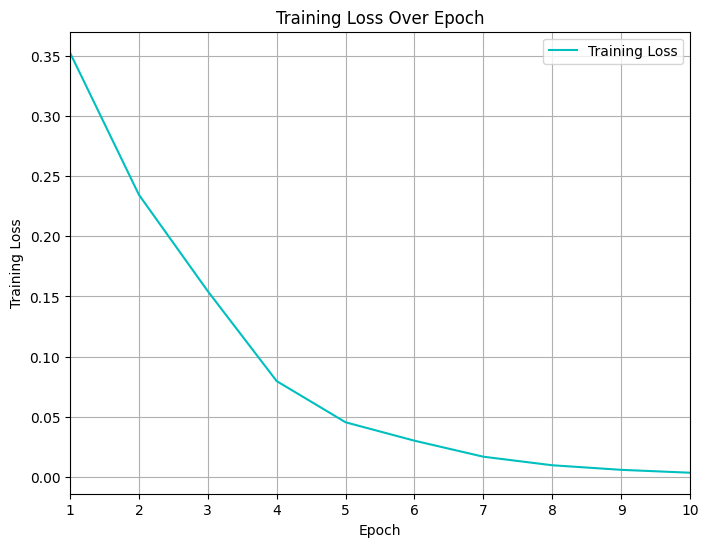

In [3]:
# This code cell is for displaying training loss over epoch wherein the lower
# the loss, the more capable the model is of generalization on seen/training data
train_loss_values = [0.352500,
                   0.234500,
                   0.154400,
                   0.079700,
                   0.045500,
                   0.030200,
                   0.016900,
                   0.009800,
                   0.006000,
                   0.003600]

# Create a line graph
plt.figure(figsize=(8, 6))
plt.plot(epoch_numbers, train_loss_values, linestyle='-', color='c', label='Training Loss')

# Customize the graph
plt.title('Training Loss Over Epoch')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.grid(True)
plt.legend()
plt.xticks(epoch_numbers)
plt.xlim(epoch_numbers[0], epoch_numbers[-1])

# Show the graph
plt.show()

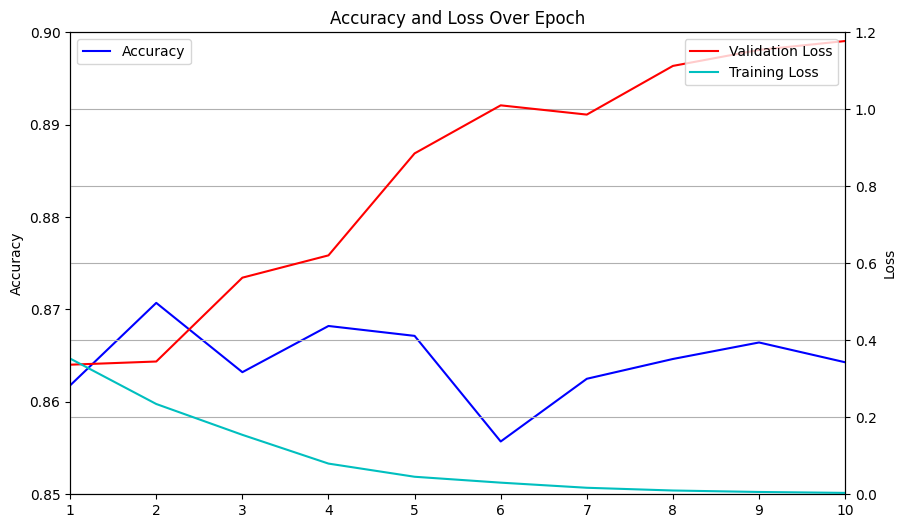

In [11]:
# Create a figure and axis
plt.figure(figsize=(10, 6))
ax1 = plt.gca()  # Primary y-axis for accuracy
ax2 = ax1.twinx()  # Secondary y-axis for loss

# Plot accuracy over epoch
ax1.plot(epoch_numbers, accuracy_values, linestyle='-', color='b', label='Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0.85, 0.90])  # Adjust the limits as needed for accuracy

# Plot validation loss over epoch on the secondary y-axis
ax2.plot(epoch_numbers, val_loss_values, linestyle='-', color='red', label='Validation Loss')
ax2.set_ylabel('Validation Loss')
ax2.set_ylim([0, 1.2])  # Adjust the limits as needed for loss

# Plot training loss over epoch on the secondary y-axis
ax2.plot(epoch_numbers, train_loss_values, linestyle='-', color='c', label='Training Loss')
ax2.set_ylabel('Loss')

# Customize the graph
plt.title('Accuracy and Loss Over Epoch')
plt.xlabel('Epoch')
plt.grid(True)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.xticks(epoch_numbers)
plt.xlim(epoch_numbers[0], epoch_numbers[-1])

# Show the graph
plt.show()

In [ ]:
# To evaluate the performance of the model on the validation dataset which was
# used during training, we create a confusion matrix based on the predictions of
# trainer.predict()

# NOTE: This evaluation of performance and confusion matrix are based on the model
# trained during 2 epochs. Therefore, this is the performance of the model at epoch 2
# during a different training session. The graphs above may be different from this
# since another training session was conducted to show the model's performance
# over 10 epochs to see where overfitting begins.

from sklearn.metrics import confusion_matrix

# Reload accuracy as ev.load("accuracy") just in case accuracy has been overwritten
accuracy = ev.load("accuracy")

# Generate predictions based on the validation dataset
predictions = trainer.predict(tokenized_hsf["validation"])

# Get the true labels and predicted labels
true_labels = predictions.label_ids
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Compute the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix on Validation Dataset:")
print(confusion)

Confusion Matrix on Validation Dataset:
[[1176  209]
 [ 153 1262]]


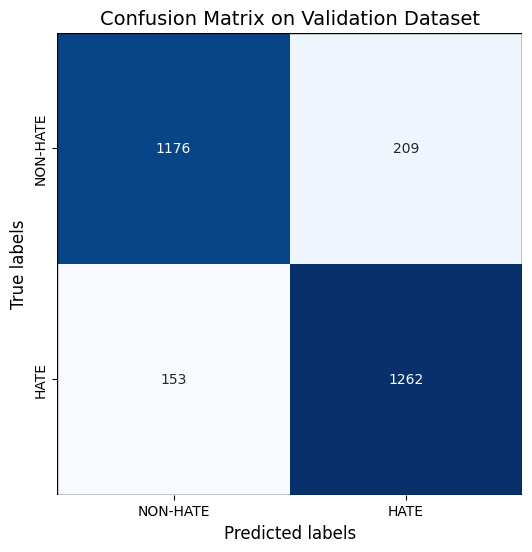

In [ ]:
import seaborn as sns

# Define class labels
class_labels = ["NON-HATE", "HATE"]

# Create a figure and axis
plt.figure(figsize=(6, 6))
ax = plt.subplot()

# Plot the heatmap
sns.heatmap(confusion, annot=True, fmt='d', cmap="Blues", cbar=False, ax=ax)

# Customize the appearance
ax.set_xlabel('Predicted labels', fontsize=12)
ax.set_ylabel('True labels', fontsize=12)
ax.set_xticklabels(class_labels, fontsize=10)
ax.set_yticklabels(class_labels, fontsize=10)
plt.title('Confusion Matrix on Validation Dataset', fontsize=14)

# Add grid lines to separate the quadrants
ax.axhline(y=0, color='k', linewidth=1)
ax.axhline(y=confusion.shape[0], color='k', linewidth=1)
ax.axvline(x=0, color='k', linewidth=1)
ax.axvline(x=confusion.shape[1], color='k', linewidth=1)

# Show the plot
plt.show()

**This section is for evaluating the model on the Test dataset and also contains the results of the model using the Test dataset**

In [ ]:
# Evaluating metrics using test dataset (Change model path to assess different model epoch training checkpoints)
# This also uses the model as an inferencing pipeline which is similar to how
# it would work when deployed, instead of using trainer.predict()

from tqdm import tqdm

# Uncomment these two if inferencing the model without training or loading the model directly
# from datasets import load_dataset
# from transformers import pipeline

import numpy as np

# Define batch size for more efficient batch processing
batch_size = 32

# Uncomment this if inferencing the model without training or loading the model directly
# hsf = load_dataset("csv", data_files = {"test": ".\combined.csv"})

# Create classifier pipeline
classifier = pipeline("text-classification", model="./roberta-tagalog-base-philippine-elections-2016-2022-hate-speech/checkpoint-2722/", device=0)

# Initialize ground_truth and predicted_labels to be empty lists
# to ensure that no other values are inside
ground_truth = []
predicted_labels = []

# Create a list of text inputs
texts = [text["text"] for text in hsf["test"]]

# Create a list of true labels
ground_truth = [text["label"] for text in hsf["test"]]

# Process the inputs in batches
for i in tqdm(range(0, len(texts), batch_size)):
    batch_texts = texts[i:i+batch_size]
    batch_predictions = classifier(batch_texts)

    # Add the batch predictions to the list of all predictions
    for prediction in batch_predictions:
        predicted_labels.append(1 if prediction["label"] == "HATE" else 0)

# Convert to numpy arrays for further processing
ground_truth = np.array(ground_truth)
predicted_labels = np.array(predicted_labels)

 11%|█▏        | 10/88 [00:03<00:28,  2.71it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 88/88 [00:36<00:00,  2.44it/s]


In [ ]:
# Compute Evaluation Metrics on the Test Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(ground_truth, predicted_labels)

# Calculate precision
precision = precision_score(ground_truth, predicted_labels)

# Calculate recall
recall = recall_score(ground_truth, predicted_labels)

# Calculate F1-score
f1 = f1_score(ground_truth, predicted_labels)

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.8701067615658363
Precision: 0.8579348579348579
Recall: 0.8855507868383404
F1-score: 0.8715241112284406


In [ ]:
# Create a confusion matrix based on the Test Dataset
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(ground_truth, predicted_labels)

print("Confusion Matrix on Test Dataset")
print(confusion)

Confusion Matrix on Test Dataset
[[1207  205]
 [ 160 1238]]


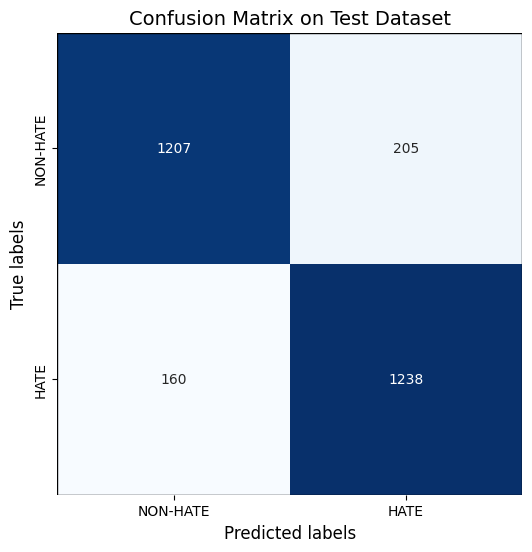

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Define class labels
class_labels = ["NON-HATE", "HATE"]

# Create a figure and axis
plt.figure(figsize=(6, 6))
ax = plt.subplot()

# Plot the heatmap
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)

# Customize the appearance
ax.set_xlabel('Predicted labels', fontsize=12)
ax.set_ylabel('True labels', fontsize=12)
ax.set_xticklabels(class_labels, fontsize=10)
ax.set_yticklabels(class_labels, fontsize=10)
plt.title('Confusion Matrix on Test Dataset', fontsize=14)

# Add grid lines to separate the quadrants
ax.axhline(y=0, color='k', linewidth=1)
ax.axhline(y=confusion.shape[0], color='k', linewidth=1)
ax.axvline(x=0, color='k', linewidth=1)
ax.axvline(x=confusion.shape[1], color='k', linewidth=1)

# Show the plot
plt.show()

**This section is for Uploading the fine-tuned ROBERTa model to the Hugging Face platform.**

In [ ]:
# Make sure to have huggingface_hub installed for logging in and pushing
%pip install huggingface_hub

In [ ]:
# Import notebook_login to login this specific notebook
from huggingface_hub import notebook_login

# Login with Hugging Face WRITE token
notebook_login()

In [ ]:
# Upload the model to the hub
trainer.push_to_hub()

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.09k [00:00<?, ?B/s]

'https://huggingface.co/mapsoriano/roberta-tagalog-base-philippine-elections-2016-2022-hate-speech/tree/main/'

**This section incldues the depracated functions and techniques used for evaluating the model on the Test dataset**

In [ ]:
# # (INDIVIDUAL PREDICTION) Evaluating metrics using test dataset (Change model path if necessary)
# from tqdm import tqdm

# classifier = pipeline("text-classification", model="./ROBERTA_TAGALOG_base/checkpoint-2692/")
# ground_truth = []
# predicted_labels = []

# for text in tqdm(hsf["test"]):
#   # Append the labels
#   ground_truth.append(text["label"])

#   processed_text = classifier(text["text"])
#   predicted_labels.append(1 if processed_text[0]["label"] == "HATE" else 0)

In [ ]:
# Used for individual evaluation of each part of the test dataset (Change model path if necessary)
# text = hsf["test"][4231]
# print(f'Text: {text["text"]}')
# print(f'Label: {"NOT HATE" if text["label"] == 0 else "HATE"}({text["label"]})')
# classifier = pipeline("text-classification", model="./DISTILBERT_cased/checkpoint-1250/")
# classifier(text["text"])

In [ ]:
# Used for individual evaluation of text input (Change model path if necessary)
# classifier = pipeline("text-classification", model="./ROBERTA_TAGALOG_base/checkpoint-2722/", device=0)
# text = "Gusto kita pero hate kita"
# print(f'Text: {text}')
# classifier(text)